In [51]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [52]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [53]:
warnings.filterwarnings('ignore')

In [337]:
#Load data
df=pd.read_csv("data/HR_Analytics.csv")
#Make a dummy variable for our response variable
df = pd.get_dummies(df, columns = ["Attrition"])

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check

*By Ally Bardas and Karrine Denisova*

We checked for class imbalance in the outcome variable through visualizations.

Description of Variables
- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

In [338]:
#There are zero missing values that need to be filled in the data set
print(df.isna().sum().sum())

0


In [44]:
# count the number of attrition entries
attrition_counts = df['Attrition_Yes'].value_counts()

# calculate the percentage out of total entries
attrition_percent = attrition_counts/attrition_counts.sum()

# make labels for plots
labels = ['Attrition_No-'+str((attrition_percent[0]*100).round(2))+'%', 'Attrition_Yes-'+str((attrition_percent[1]*100).round(2))+'%']

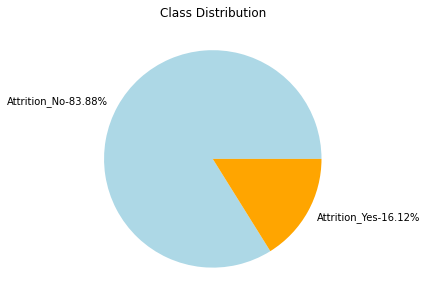

In [45]:
# check for class imbalance of the outcome variable
plt.pie(attrition_counts, labels=labels, colors=['lightblue', 'orange'])
plt.title('Class Distribution')
plt.show()

<AxesSubplot:xlabel='Attrition_Yes', ylabel='MonthlyIncome'>

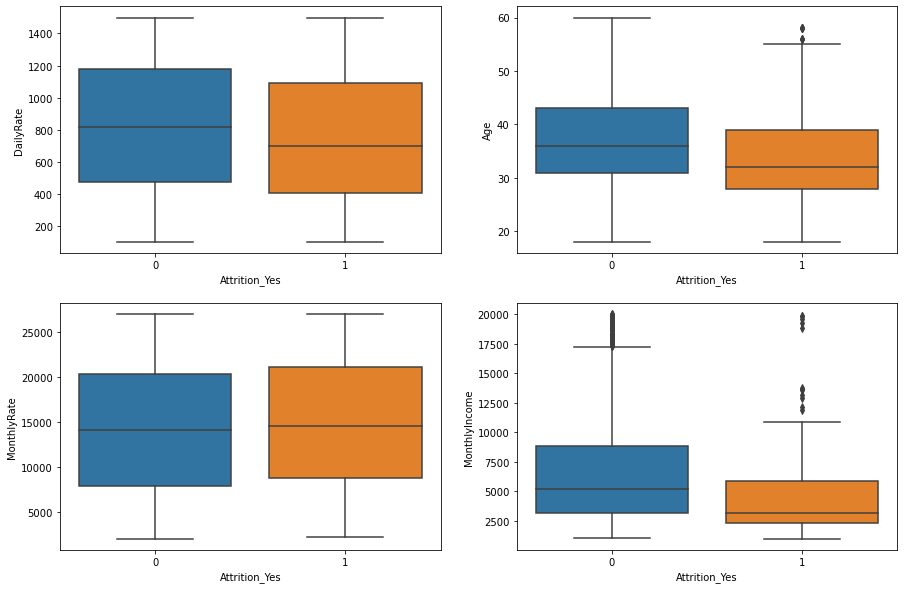

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.boxplot(data=df, x='Attrition_Yes', y='DailyRate', ax=axes[0, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='Age', ax=axes[0, 1])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyRate', ax=axes[1, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyIncome', ax=axes[1, 1])

### Data cleaning
*By Ally Bardas*


From the data quality check we realized that:

1. Needed to make dummy variables before splitting our data into train and test.

2. Dropped redundant/unnecessary variables.

3. Created train and test data.

The code below implements the above cleaning.

In [342]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [344]:
#Drop employee count, over 18 and standard hours because they are the same value for every person, and EmployeeNumber because it is just an identification number
df = df.drop(["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"], axis = 1)

In [345]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

No. of training examples: 1029
No. of testing examples: 441


In [347]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


### Data preparation
*By Ally Bardas*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Turn all categorical variables into dummy variables

2. Use oversampling of the minority class to account for class imbalance in our train and test data.

In [348]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [349]:
#Turn all categorical variables into dummy variables
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

In [350]:
#Make dummy variables for all variables in the test dataset as well
test = test.rename(columns=lambda x: x.strip())

test = pd.get_dummies(test, drop_first = True)
test.columns = test.columns.str.replace('-', '')
test.columns = test.columns.str.replace(' ', '')
test.columns = test.columns.str.replace('&', '_')

test = pd.get_dummies(test, drop_first = True)

In [351]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [352]:
y_train_resampled.name = 'Attrition_Yes'

In [353]:
#We will need a copy of the train dataset later on to test the final model
X_train_for_final = X_train_resampled.copy()

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

*By Catherine Erickson, Annabel Skubisz, and Ally Bardas* 

<AxesSubplot:>

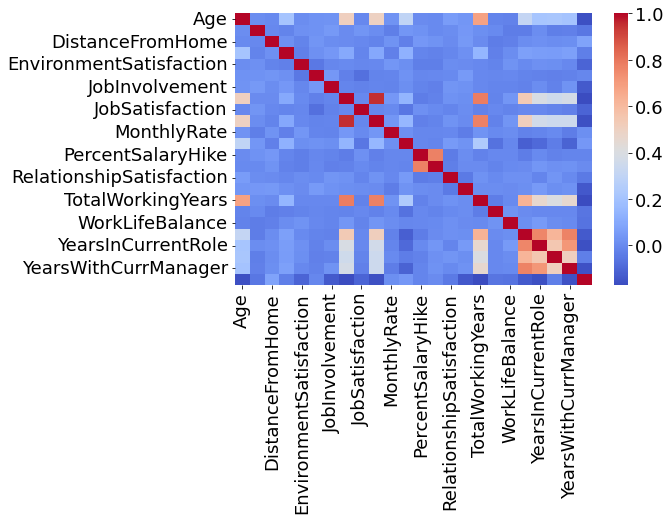

In [354]:
#Creating a heatmap of all variables - there is some high multi-collinearity
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [355]:
#To determine which variables are multicollinear, we check VIF and drop variables with VIF>10 one-by-one
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  594.578000
26   Department_Research_Development   74.026729
27                  Department_Sales   71.728172
28       EducationField_LifeSciences   22.096104
40            JobRole_SalesExecutive   19.540438
30            EducationField_Medical   19.515725
10                     MonthlyIncome   18.169366
8                           JobLevel   15.413133
34            JobRole_HumanResources   13.681386
41       JobRole_SalesRepresentative   11.529127
29          EducationField_Marketing   10.289840
32    EducationField_TechnicalDegree    9.636047
31              EducationField_Other    6.444889
17                 TotalWorkingYears    5.439171
20                    YearsAtCompany    5.199649
35      JobRole_LaboratoryTechnician    4.794969
39         JobRole_ResearchScientist    4.696601
36                   JobRole_Manager    4.003627
43              MaritalStatus_Single    3.463383
24  BusinessTravel_T

In [356]:
# Drop the feature with the greatest VIF (Department_Research_Development)
col_to_drop = ["Department_Research_Development"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [357]:
#Retesting VIF without Department_Research_Development
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  352.159496
26                  Department_Sales   20.584710
27       EducationField_LifeSciences   20.522990
39            JobRole_SalesExecutive   18.395502
10                     MonthlyIncome   18.161001
29            EducationField_Medical   18.046137
8                           JobLevel   15.404845
40       JobRole_SalesRepresentative   10.886717
28          EducationField_Marketing    9.607128
31    EducationField_TechnicalDegree    8.989853
30              EducationField_Other    6.026375
17                 TotalWorkingYears    5.420776
20                    YearsAtCompany    5.186741
34      JobRole_LaboratoryTechnician    4.790690
38         JobRole_ResearchScientist    4.693639
35                   JobRole_Manager    3.737150
42              MaritalStatus_Single    3.461115
24  BusinessTravel_Travel_Frequently    3.192411
25      BusinessTravel_Travel_Rarely    3.183141
21                Ye

In [358]:
# Drop the feature with the greatest VIF (Department_Sales)
col_to_drop = ["Department_Sales"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [359]:
#Retesting VIF without Department_Sales
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  352.134854
26       EducationField_LifeSciences   20.419391
10                     MonthlyIncome   18.130602
28            EducationField_Medical   17.999846
8                           JobLevel   15.400136
27          EducationField_Marketing    9.448076
30    EducationField_TechnicalDegree    8.951865
29              EducationField_Other    6.007729
17                 TotalWorkingYears    5.420771
20                    YearsAtCompany    5.126763
33      JobRole_LaboratoryTechnician    4.790662
37         JobRole_ResearchScientist    4.693455
38            JobRole_SalesExecutive    3.626901
41              MaritalStatus_Single    3.459969
39       JobRole_SalesRepresentative    3.240325
24  BusinessTravel_Travel_Frequently    3.190972
25      BusinessTravel_Travel_Rarely    3.178232
21                YearsInCurrentRole    3.111454
34                   JobRole_Manager    2.996257
23              Year

In [360]:
# Drop the feature with the greatest VIF (EducationField_LifeSciences)
col_to_drop = ["EducationField_LifeSciences"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [361]:
#Retesting VIF without EducationField_LifeSciences
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  273.999226
10                     MonthlyIncome   18.129896
8                           JobLevel   15.399262
17                 TotalWorkingYears    5.418369
20                    YearsAtCompany    5.122283
32      JobRole_LaboratoryTechnician    4.789527
36         JobRole_ResearchScientist    4.693340
37            JobRole_SalesExecutive    3.625020
40              MaritalStatus_Single    3.459456
38       JobRole_SalesRepresentative    3.239970
24  BusinessTravel_Travel_Frequently    3.190929
25      BusinessTravel_Travel_Rarely    3.175064
21                YearsInCurrentRole    3.111424
33                   JobRole_Manager    2.989378
23              YearsWithCurrManager    2.868722
13                 PercentSalaryHike    2.573785
14                 PerformanceRating    2.561445
35          JobRole_ResearchDirector    2.488169
1                                Age    2.191816
39             Marit

In [362]:
# Drop the feature with the greatest VIF (MonthlyIncome)
col_to_drop = ["MonthlyIncome"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [363]:
#Retesting VIF without MonthlyIncome
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  273.671159
8                           JobLevel    7.017203
16                 TotalWorkingYears    5.335696
19                    YearsAtCompany    5.118689
31      JobRole_LaboratoryTechnician    4.761054
35         JobRole_ResearchScientist    4.680194
36            JobRole_SalesExecutive    3.621233
39              MaritalStatus_Single    3.459412
37       JobRole_SalesRepresentative    3.200131
23  BusinessTravel_Travel_Frequently    3.187919
24      BusinessTravel_Travel_Rarely    3.169580
20                YearsInCurrentRole    3.111106
22              YearsWithCurrManager    2.851781
12                 PercentSalaryHike    2.572663
13                 PerformanceRating    2.558472
32                   JobRole_Manager    2.242789
1                                Age    2.190379
38             MaritalStatus_Married    2.149920
15                  StockOptionLevel    1.971203
33     JobRole_Manuf

**All VIFs are under our threshold of 10 now.**

In [364]:
# Making "train" a dataframe with the dummy variables, highly correlated variables dropped, and with the response
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [365]:
# Concating test with the response variable
test = pd.concat([X_test, pd.DataFrame(y_test)],axis =1)

**Visualizing Transformations on Continuous Variables to determine possible transformations.**

*By Catherine Erickson and Annabel Skubisz*

Text(0.5, 1.0, 'Attrition Percent based on Job Level')

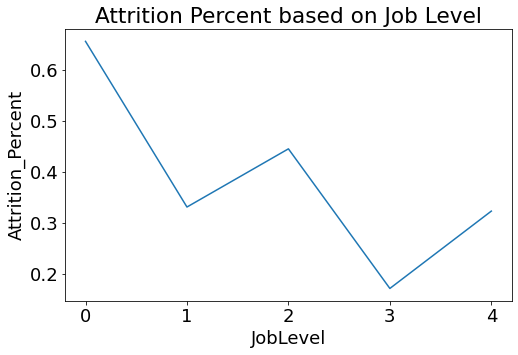

In [366]:
JobLevel_data = train.groupby('JobLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobLevel_data.index, y= JobLevel_data['Attrition_Percent'])
plt.xlabel('JobLevel')
plt.title("Attrition Percent based on Job Level")

Text(0.5, 1.0, 'Attrition Percent based on TotalWorkingYears')

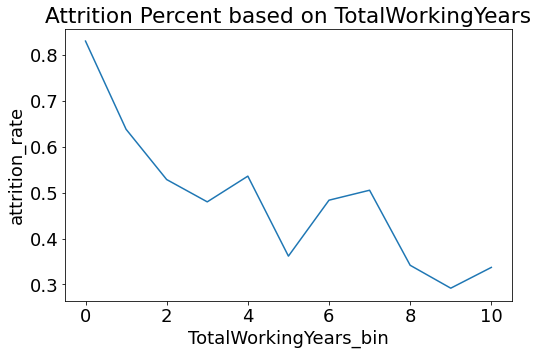

In [367]:
binned_workingyears = pd.qcut(train['TotalWorkingYears'],11,retbins=True)
train['workingyears_binned'] = binned_workingyears[0]
workingyears_data = train.groupby('workingyears_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = workingyears_data.index, y= workingyears_data['attrition_rate'])
plt.xlabel('TotalWorkingYears_bin')
plt.title("Attrition Percent based on TotalWorkingYears")

Text(0.5, 1.0, 'Attrition Percent based on YearsAtCompany')

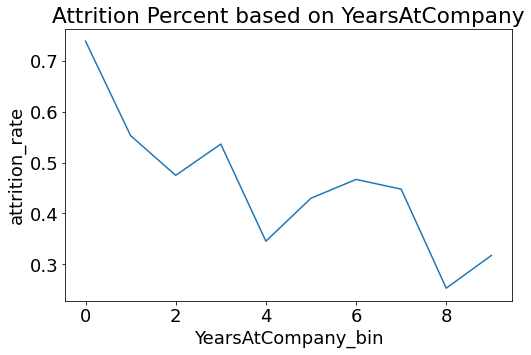

In [368]:
binned_company = pd.qcut(train['YearsAtCompany'],11,retbins=True, duplicates="drop")
train['company_binned'] = binned_company[0]
company_data = train.groupby('company_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = company_data.index, y= company_data['attrition_rate'])
plt.xlabel('YearsAtCompany_bin')
plt.title("Attrition Percent based on YearsAtCompany")

Text(0.5, 1.0, 'Attrition Percent based on YearsInCurrentRole')

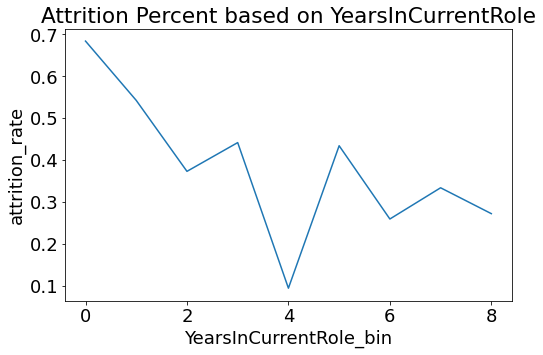

In [369]:
binned_YearsInCurrentRole = pd.qcut(train['YearsInCurrentRole'],20,retbins=True, duplicates="drop")
train['YearsInCurrentRole_binned'] = binned_YearsInCurrentRole[0]
YearsInCurrentRole_data = train.groupby('YearsInCurrentRole_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsInCurrentRole_data.index, y= YearsInCurrentRole_data['attrition_rate'])
plt.xlabel('YearsInCurrentRole_bin')
plt.title("Attrition Percent based on YearsInCurrentRole")

Text(0.5, 1.0, 'Attrition Percent based on YearsWithCurrManager')

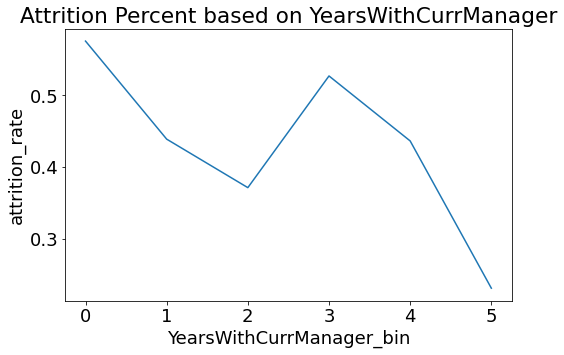

In [370]:
binned_YearsWithCurrManager = pd.qcut(train['YearsWithCurrManager'],10,retbins=True, duplicates="drop")
train['YearsWithCurrManager_binned'] = binned_YearsWithCurrManager[0]
YearsWithCurrManager_data = train.groupby('YearsWithCurrManager_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsWithCurrManager_data.index, y= YearsWithCurrManager_data['attrition_rate'])
plt.xlabel('YearsWithCurrManager_bin')
plt.title("Attrition Percent based on YearsWithCurrManager")

Text(0.5, 1.0, 'Attrition Percent based on PercentSalaryHike')

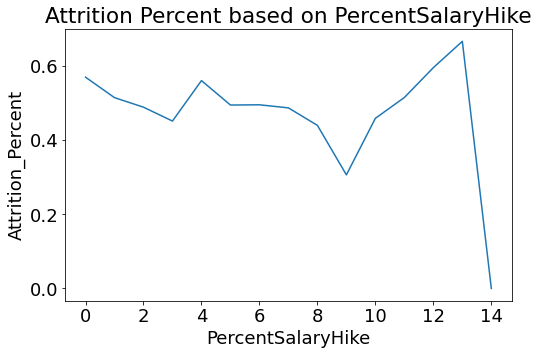

In [371]:
PercentSalaryHike_data = train.groupby('PercentSalaryHike')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = PercentSalaryHike_data.index, y= PercentSalaryHike_data['Attrition_Percent'])
plt.xlabel('PercentSalaryHike')
plt.title("Attrition Percent based on PercentSalaryHike")

Text(0.5, 1.0, 'Attrition Percent based on Age')

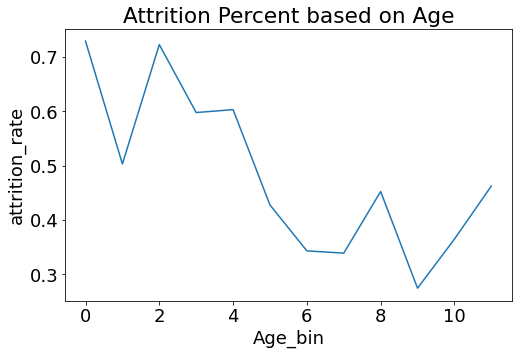

In [372]:
binned_age = pd.qcut(train['Age'],12,retbins=True)
train['age_binned'] = binned_age[0]
age_data = train.groupby('age_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['attrition_rate'])
plt.xlabel('Age_bin')
plt.title("Attrition Percent based on Age")

Text(0.5, 1.0, 'Attrition Percent based on Stock Option Level')

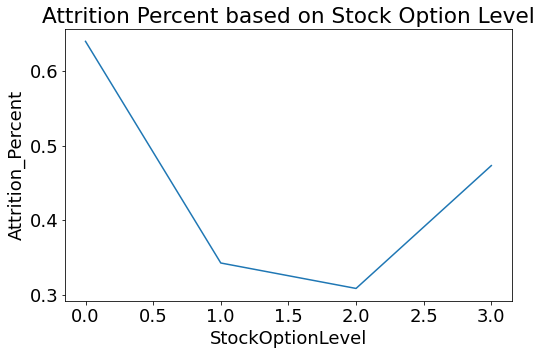

In [373]:
Stock_data = train.groupby('StockOptionLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('StockOptionLevel')
plt.title("Attrition Percent based on Stock Option Level")

Text(0.5, 1.0, 'Attrition Percent based on YearsSinceLastPromotion')

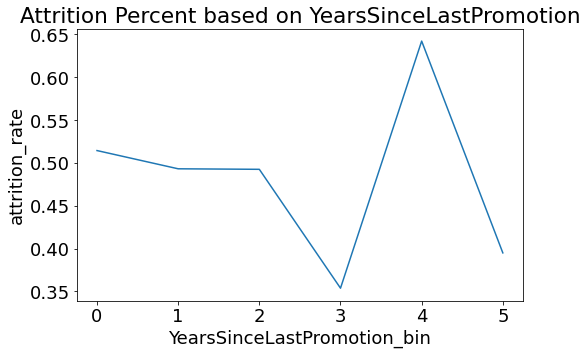

In [374]:
binned_YearsSinceLastPromotion = pd.qcut(train['YearsSinceLastPromotion'],15,retbins=True, duplicates="drop")
train['YearsSinceLastPromotion_binned'] = binned_YearsSinceLastPromotion[0]
YearsSinceLastPromotion_data = train.groupby('YearsSinceLastPromotion_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsSinceLastPromotion_data.index, y= YearsSinceLastPromotion_data['attrition_rate'])
plt.xlabel('YearsSinceLastPromotion_bin')
plt.title("Attrition Percent based on YearsSinceLastPromotion")

Text(0.5, 1.0, 'Attrition Percent based on Number of Companies Worked')

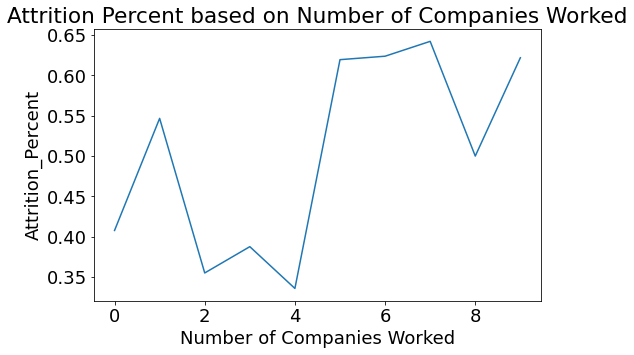

In [375]:
NumCompaniesWorked_data = train.groupby('NumCompaniesWorked')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = NumCompaniesWorked_data.index, y= NumCompaniesWorked_data['Attrition_Percent'])
plt.xlabel('Number of Companies Worked')
plt.title("Attrition Percent based on Number of Companies Worked")

Text(0.5, 1.0, 'Attrition Percent based on Education Level')

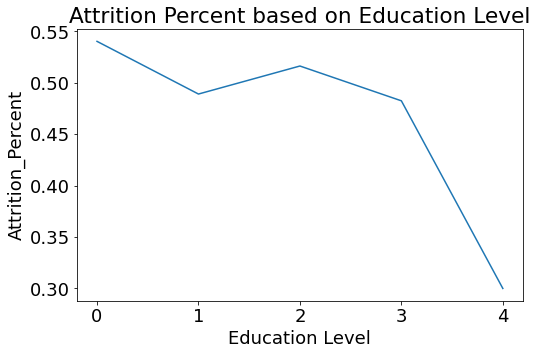

In [376]:
Education_data = train.groupby('Education')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Education_data.index, y= Education_data['Attrition_Percent'])
plt.xlabel('Education Level')
plt.title("Attrition Percent based on Education Level")

Text(0.5, 1.0, 'Attrition Percent based on WorkLifeBalance')

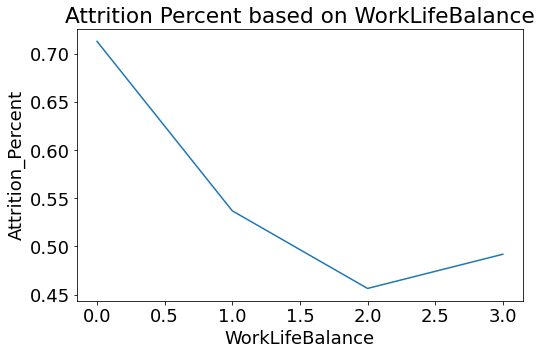

In [377]:
WorkLifeBalance_data = train.groupby('WorkLifeBalance')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = WorkLifeBalance_data.index, y= WorkLifeBalance_data['Attrition_Percent'])
plt.xlabel('WorkLifeBalance')
plt.title("Attrition Percent based on WorkLifeBalance")

Text(0.5, 1.0, 'Attrition Percent based on MonthlyRate')

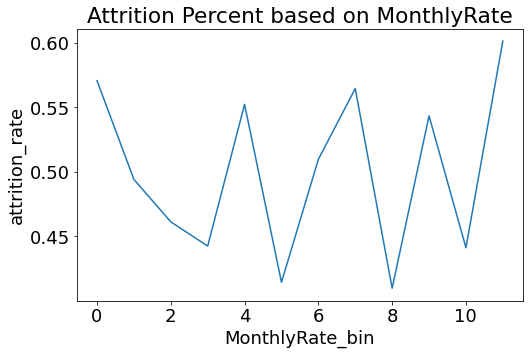

In [378]:
binned_MonthlyRate = pd.qcut(train['MonthlyRate'],12,retbins=True)
train['MonthlyRate_binned'] = binned_MonthlyRate[0]
MonthlyRate_data = train.groupby('MonthlyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = MonthlyRate_data.index, y= MonthlyRate_data['attrition_rate'])
plt.xlabel('MonthlyRate_bin')
plt.title("Attrition Percent based on MonthlyRate")

Text(0.5, 1.0, 'Attrition Percent based on DistanceFromHome')

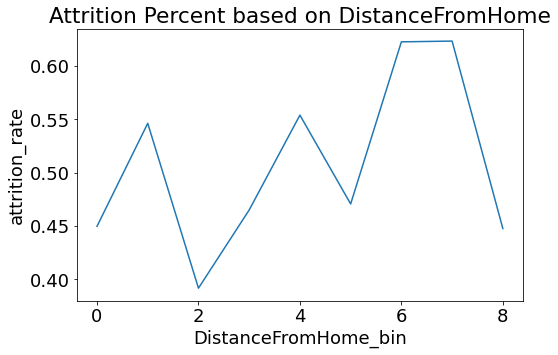

In [379]:
binned_distance = pd.qcut(train['DistanceFromHome'],10,retbins=True, duplicates="drop")
train['distance_binned'] = binned_distance[0]
distance_data = train.groupby('distance_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = distance_data.index, y= distance_data['attrition_rate'])
plt.xlabel('DistanceFromHome_bin')
plt.title("Attrition Percent based on DistanceFromHome")

Text(0.5, 1.0, 'Attrition Percent based on DailyRate')

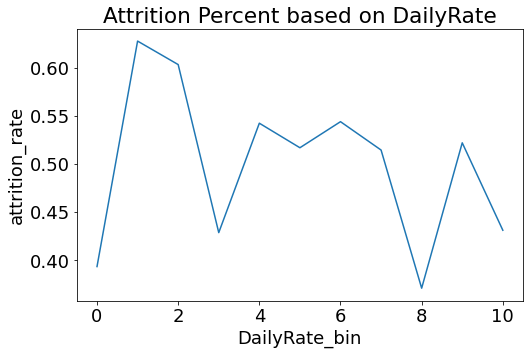

In [380]:
binned_DailyRate = pd.qcut(train['DailyRate'],11,retbins=True)
train['DailyRate_binned'] = binned_DailyRate[0]
DailyRate_data = train.groupby('DailyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = DailyRate_data.index, y= DailyRate_data['attrition_rate'])
plt.xlabel('DailyRate_bin')
plt.title("Attrition Percent based on DailyRate")

Text(0.5, 1.0, 'Attrition Percent based on JobSatisfaction')

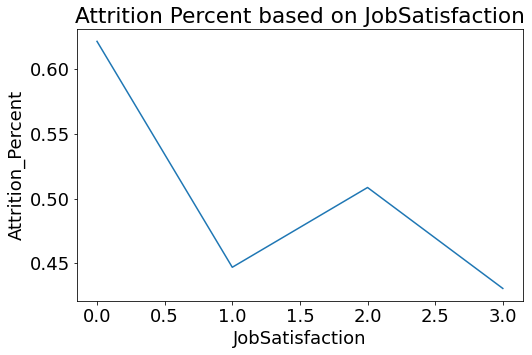

In [381]:
JobSatisfaction_data = train.groupby('JobSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobSatisfaction_data.index, y= JobSatisfaction_data['Attrition_Percent'])
plt.xlabel('JobSatisfaction')
plt.title("Attrition Percent based on JobSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on EnvironmentSatisfaction')

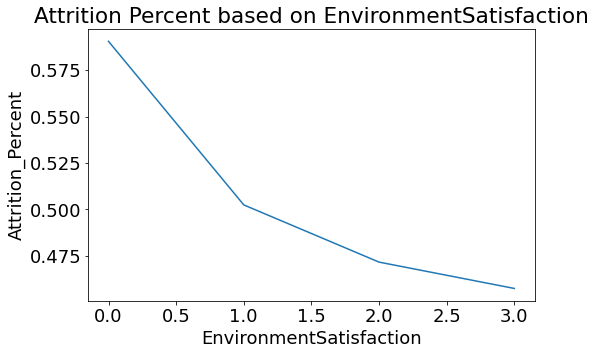

In [382]:
EnvironmentSatisfaction_data = train.groupby('EnvironmentSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = EnvironmentSatisfaction_data.index, y= EnvironmentSatisfaction_data['Attrition_Percent'])
plt.xlabel('EnvironmentSatisfaction')
plt.title("Attrition Percent based on EnvironmentSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on RelationshipSatisfaction')

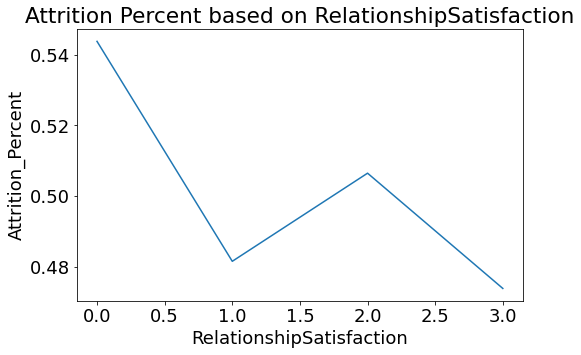

In [383]:
RelationshipSatisfaction_data = train.groupby('RelationshipSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = RelationshipSatisfaction_data.index, y= RelationshipSatisfaction_data['Attrition_Percent'])
plt.xlabel('RelationshipSatisfaction')
plt.title("Attrition Percent based on RelationshipSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on TrainingTimesLastYear')

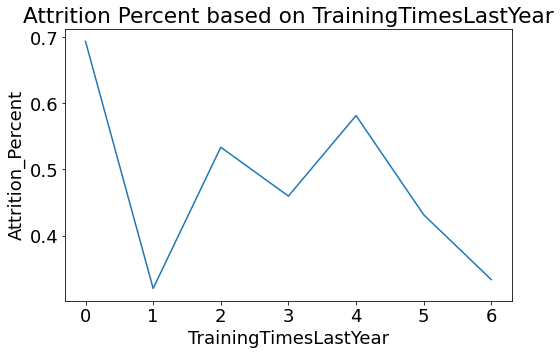

In [384]:
TrainingTimesLastYear_data = train.groupby('TrainingTimesLastYear')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = TrainingTimesLastYear_data.index, y= TrainingTimesLastYear_data['Attrition_Percent'])
plt.xlabel('TrainingTimesLastYear')
plt.title("Attrition Percent based on TrainingTimesLastYear")

Text(0.5, 1.0, 'Attrition Percent based on JobInvolvement')

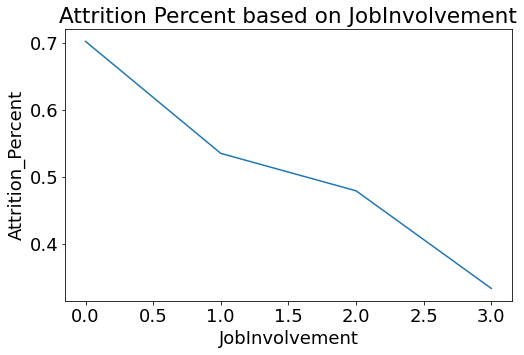

In [385]:
JobInvolvement_data = train.groupby('JobInvolvement')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobInvolvement_data.index, y= JobInvolvement_data['Attrition_Percent'])
plt.xlabel('JobInvolvement')
plt.title("Attrition Percent based on JobInvolvement")

Text(0.5, 1.0, 'Attrition Percent based on HourlyRate')

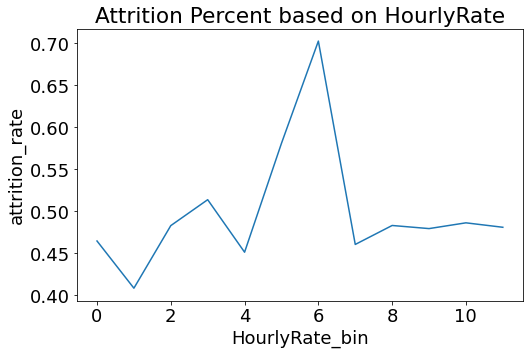

In [386]:
binned_HourlyRate = pd.qcut(train['HourlyRate'],12,retbins=True)
train['HourlyRate_binned'] = binned_HourlyRate[0]
HourlyRate_data = train.groupby('HourlyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = HourlyRate_data.index, y= HourlyRate_data['attrition_rate'])
plt.xlabel('HourlyRate_bin')
plt.title("Attrition Percent based on HourlyRate")

**Insights for Possible Transformations - quadratic transformations were determined by graphs that had a slight U-shape, and log transformations were determined by graphs that had a tail.**

YearsInCurrentRole - quadratic

PercentSalaryHike - log

StockOptionLevel - quadratic

YearsSinceLastPromotion - quadratic

NumCompaniesWorked - quadratic

Education - log

WorkLifeBalance - log

DailyRate - quadratic

TrainingTimesLastYear - quadratic

HourlyRate - quadratic

**These transformations will be included in forward selection to see if any of them improve the model.**

*Catherine Erickson and Karrine Denisova*

In [387]:
#Since we already have a lot of categorical variables, we decided to focus on transforming variables, rather than binning.
train = train.drop(columns = ['workingyears_binned', 'company_binned',
       'YearsInCurrentRole_binned', 'YearsWithCurrManager_binned',
       'age_binned', 'YearsSinceLastPromotion_binned', 'MonthlyRate_binned',
       'distance_binned', 'DailyRate_binned', 'HourlyRate_binned'])

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

**Baseline Model**

*By Annabel Skubisz and Karrine Denisova*

In [388]:
#Logistic regression model with all predictors - baseline model
column_list = train.columns.to_list()[:-1] #not including Attrition
formula = 'Attrition_Yes~'+'+'.join(column_list)

logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.429976
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1915
Method:                           MLE   Df Model:                           40
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3797
Time:                        12:01:18   Log-Likelihood:                -841.03
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                7.811e-190
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9505      1.031      0.922      0.357      -1.071       2.972
Age                                 -0.0196      0.009     -2.077      0.038      -0.038      -0.001
DailyRate                           -0.0002      0.000     -1.373      0.170      -0.001    9.47e-05
DistanceFromHome                     0.0415      0.008      5.250      0.000       0.026       0.057
Education                            0.0378      0.062      0.612      0.541      -0.083       0.159
EnvironmentSatisfaction             -0.3803      0.060     -6.325      0.000      -0.498      -0.262
HourlyRate                           0.0017      0.003      0.526      0.599      -0.005       0.008
JobInvolvement                      -0.4697      0.091     -5.166      0.000      -0.648      -0.292
JobLevel                             0.2216      0.161      1.373      0.170      -0.095       0.538
JobSatisfaction                     -0.3425      0.059     -5.824      0.000      -0.458      -0.227
MonthlyRate                       1.632e-05   8.86e-06      1.842      0.066   -1.05e-06    3.37e-05
NumCompaniesWorked                   0.1909      0.028      6.921      0.000       0.137       0.245
PercentSalaryHike                   -0.0488      0.027     -1.808      0.071      -0.102       0.004
PerformanceRating                   -0.0988      0.280     -0.353      0.724      -0.647       0.449
RelationshipSatisfaction            -0.1310      0.057     -2.300      0.021      -0.243      -0.019
StockOptionLevel                    -0.1504      0.101     -1.490      0.136      -0.348       0.047
TotalWorkingYears                   -0.0854      0.020     -4.282      0.000      -0.124      -0.046
TrainingTimesLastYear               -0.1467      0.049     -2.991      0.003      -0.243      -0.051
WorkLifeBalance                     -0.4764      0.088     -5.418      0.000      -0.649      -0.304
YearsAtCompany                       0.1868      0.024      7.872      0.000       0.140       0.233
YearsInCurrentRole                  -0.1990      0.033     -6.120      0.000      -0.263      -0.135
YearsSinceLastPromotion              0.1320      0.028      4.740      0.000       0.077       0.187
YearsWithCurrManager                -0.1498      0.030     -4.995      0.000      -0.209      -0.091
BusinessTravel_Travel_Frequently     1.7827      0.282      6.311      0.000       1.229       2.336
BusinessTravel_Travel_Rarely         1.0796      0.257      4.194      0.000       0.575       1.584
EducationField_Marketing             0.1505      0.248      0.608      0.543      -0.335       0.636
EducationField_Medical               0.2469      0.149      1.657      0.098      -0.045       0.539
EducationField_Other                 0.6768      0.265      2.552      0.011       0.157       1.196
EducationField_TechnicalDegree       1.6682      0.227      7.362      0.000       1.224       2.112
Gender_Ma

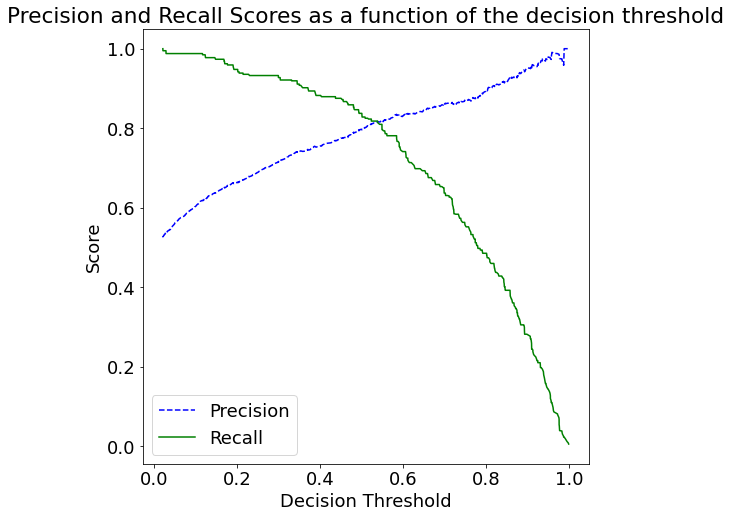

In [389]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [390]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 79.6%
Precision = 83.1%
TPR or Recall = 74.1%
FNR = 25.9%
FPR = 15.0%
ROC-AUC = 88.3%


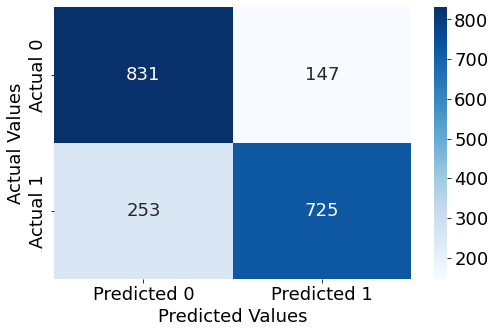

In [391]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.6)

Classification accuracy = 77.6%
Precision = 29.9%
TPR or Recall = 51.3%
FNR = 48.7%
FPR = 18.4%
ROC-AUC = 76.4%


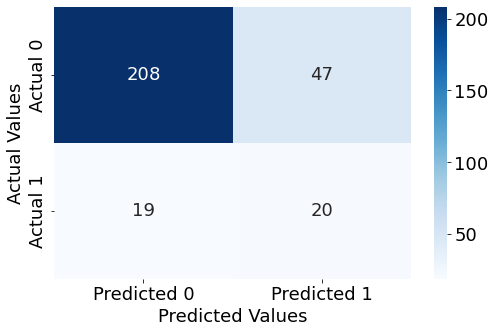

In [392]:
confusion_matrix_data(test,test.Attrition_Yes,logit_model,0.6)

0.8831721178817419


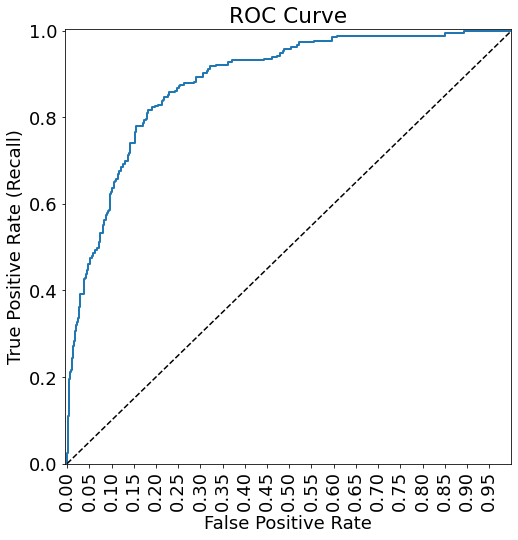

In [393]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

**Adding Transformations to DataFrame**

*By Annabel Skubisz, Karrine Denisova, and Catherine Erickson*

In [394]:
#We will need a copy of this dataframe later to test the model
train_transformations = train.copy()
train_singular = train_transformations.copy()

In [395]:
#Creating columns of the possible transformations so they are included in forward selection
train_transformations[['YearsInCurrentRole_quadratic', 'StockOptionLevel_quadratic', 'YearsSinceLastPromotion_quadratic', 'DailyRate_quadratic', 'TrainingTimesLastYear_quadratic', 'HourlyRate_quadratic']] = train_transformations[['YearsInCurrentRole', 'StockOptionLevel', 'YearsSinceLastPromotion', 'DailyRate', 'TrainingTimesLastYear', 'HourlyRate']].apply(lambda x: x**2)
train_transformations[['PercentSalaryHike_log', 'Education_log', 'WorkLifeBalance_log']] = train_transformations[['PercentSalaryHike', 'Education', 'WorkLifeBalance']].apply(lambda x: np.log(x))

**Performing Forward Selection with transformations but without interactions**

*By Catherine Erickson*

In [396]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train_transformations.drop(columns = ["Attrition_Yes"])

In [397]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train_transformations).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [398]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [399]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [400]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.589536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603409
  

Optimization terminated successfully.
         Current function value: 0.567642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564345
  

Optimization terminated successfully.
         Current function value: 0.558655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551258
         Iterations 6
Processed  44 models on 6 predictors in 0.45792198181152344 seconds.
Optimization terminated successfully.
         Current function value: 0.549674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543638
         Iterations 6
Optimization 

Optimization terminated successfully.
         Current function value: 0.530223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532025
  

Optimization terminated successfully.
         Current function value: 0.518312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519487
  

Optimization terminated successfully.
         Current function value: 0.499836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499880
  

Optimization terminated successfully.
         Current function value: 0.490828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490791
  

Optimization terminated successfully.
         Current function value: 0.469487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469714
  

Optimization terminated successfully.
         Current function value: 0.456157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455147
  

Optimization terminated successfully.
         Current function value: 0.450696
         Iterations 7
Processed  27 models on 23 predictors in 0.7563948631286621 seconds.
Optimization terminated successfully.
         Current function value: 0.446541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446499
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.440022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440042
  

Optimization terminated successfully.
         Current function value: 0.427380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426902
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427418
  

Optimization terminated successfully.
         Current function value: 0.422391
         Iterations 7
Processed  15 models on 35 predictors in 0.942176103591919 seconds.
Optimization terminated successfully.
         Current function value: 0.421085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421295
         Iterations 7
Optimization t

Optimization terminated successfully.
         Current function value: 0.412571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412551
         Iterations 7
Processed  7 models on 43 predictors in 0.344973087310791 seconds.
Optimization terminated successfully.
         Current function value: 0.412341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412414
         Iterations 7
Optimization te

In [401]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest Log-Likelihood statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

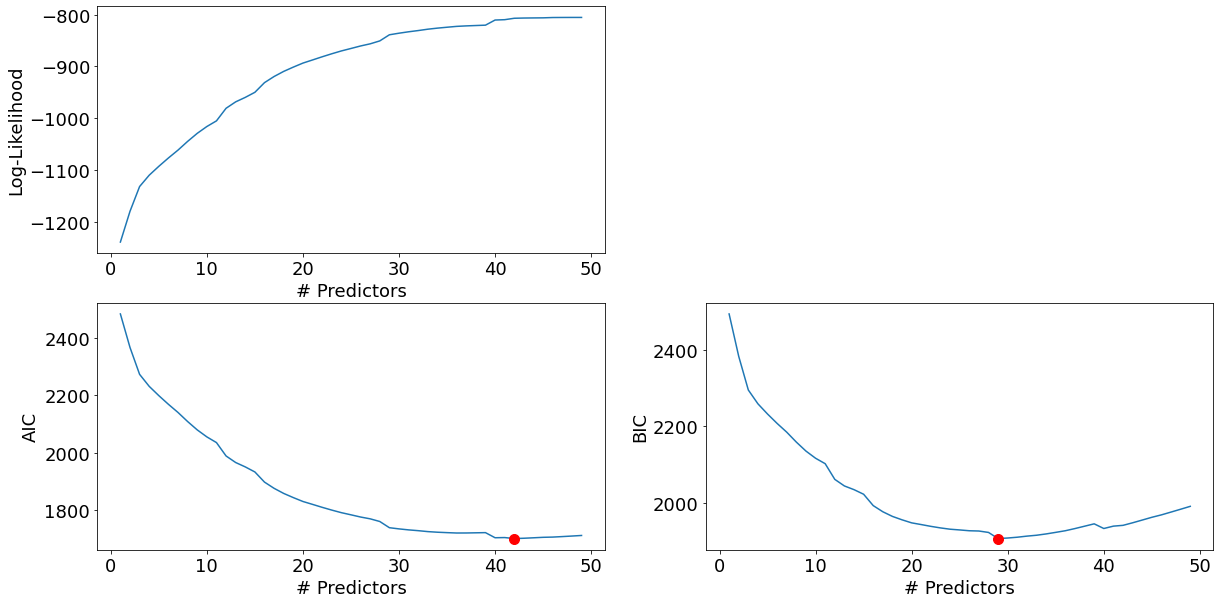

In [402]:
best_sub_plots()

In [403]:
##BIC selected 29 predictors
singular_fwd_reg_model = models_best['logit_model'][29]
singular_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1926
Method:                           MLE   Df Model:                           29
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3811
Time:                        12:02:23   Log-Likelihood:                -839.10
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                7.580e-199
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.6250      1.021      2.571      0.010       0.624       4.626
OverTime_Yes                          2.0456      0.137     14.965      0.000       1.778       2.314
MaritalStatus_Single                  1.9438      0.187     10.370      0.000       1.576       2.311
JobLevel                              0.1351      0.144      0.938      0.348      -0.147       0.418
JobInvolvement                       -0.5173      0.089     -5.788      0.000      -0.693      -0.342
JobRole_ResearchScientist             0.5297      0.279      1.895      0.058      -0.018       1.077
EducationField_TechnicalDegree        1.4998      0.210      7.145      0.000       1.088       1.911
EnvironmentSatisfaction              -0.3446      0.059     -5.877      0.000      -0.459      -0.230
WorkLifeBalance_log                  -1.1774      0.196     -6.007      0.000      -1.562      -0.793
JobSatisfaction                      -0.3362      0.057     -5.918      0.000      -0.447      -0.225
BusinessTravel_Travel_Frequently      1.8902      0.282      6.704      0.000       1.338       2.443
YearsSinceLastPromotion_quadratic    -0.0051      0.005     -0.953      0.341      -0.016       0.005
YearsInCurrentRole                   -0.4811      0.061     -7.902      0.000      -0.600      -0.362
YearsInCurrentRole_quadratic          0.0254      0.004      5.833      0.000       0.017       0.034
YearsAtCompany                        0.1839      0.025      7.435      0.000       0.135       0.232
NumCompaniesWorked                    0.1746      0.027      6.388      0.000       0.121       0.228
TotalWorkingYears                    -0.1103      0.018     -6.033      0.000      -0.146      -0.074
DistanceFromHome                      0.0466      0.008      5.952      0.000       0.031       0.062
BusinessTravel_Travel_Rarely          1.1473      0.256      4.480      0.000       0.645       1.649
MaritalStatus_Married                 0.7355      0.175      4.192      0.000       0.392       1.079
JobRole_ResearchDirector             -1.7271      0.546     -3.161      0.002      -2.798      -0.656
YearsWithCurrManager                 -0.1090      0.031     -3.475      0.001      -0.170      -0.048
Gender_Male                           0.4572      0.129      3.537      0.000       0.204       0.711
PercentSalaryHike_log                -0.9299      0.282     -3.297      0.001      -1.483      -0.377
YearsSinceLastPromotion               0.1674      0.061      2.739      0.006       0.048       0.287
JobRole_SalesRepresentative           2.1763      0.335      6.498      0.000       1.520       2.833
TrainingTimesLastYear                -0.1416      0.049     -2.873      0.004      -0.238      -0.045
JobRole_LaboratoryTechnician          1.6246      0.276      5.894      0.000       1.084       2.165
JobRole_HumanResources                1.7945      0.369      4.862      0.000  

**Creating interaction terms**

*By Annabel Skubisz, Ally Bardas, and Karrine Denisova*

In [404]:
#Since these categorical variables have a lot of levels, they kept giving a singular matrix error in forward selection
#So, we dropped all levels but one of JobRole and EducationField
train = train.drop(['JobRole_HumanResources', 'JobRole_LaboratoryTechnician', 'JobRole_Manager', 'JobRole_ManufacturingDirector', 'JobRole_ResearchDirector', 'JobRole_SalesExecutive', 'JobRole_SalesRepresentative', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other'], axis = 1)

#Making a dataframe of just predictors
X_train_resampled = train.drop(columns = ["Attrition_Yes"])

In [405]:
#Creating interaction terms between all variabls, excluding interactions between dummies of the same category
import itertools

X_backup = X_train_resampled.copy()
interactions = pd.DataFrame()

for combo in itertools.combinations(X_backup.columns, 2):
    prefix1 = combo[0][:combo[0].rfind('_')].split('_')[0]
    prefix2 = combo[1][:combo[1].rfind('_')].split('_')[0]
    if prefix1 != prefix2:
        train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
        test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
        X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
        interactions.loc[:,'_'.join(combo)] = X_train_resampled.loc[:,'_'.join(combo)]
        #only make interaction terms if the prefix(before the last underscore) of combo[0] is not the same as that of of combo[1]
        # Add the other code here under the if condition

<AxesSubplot:>

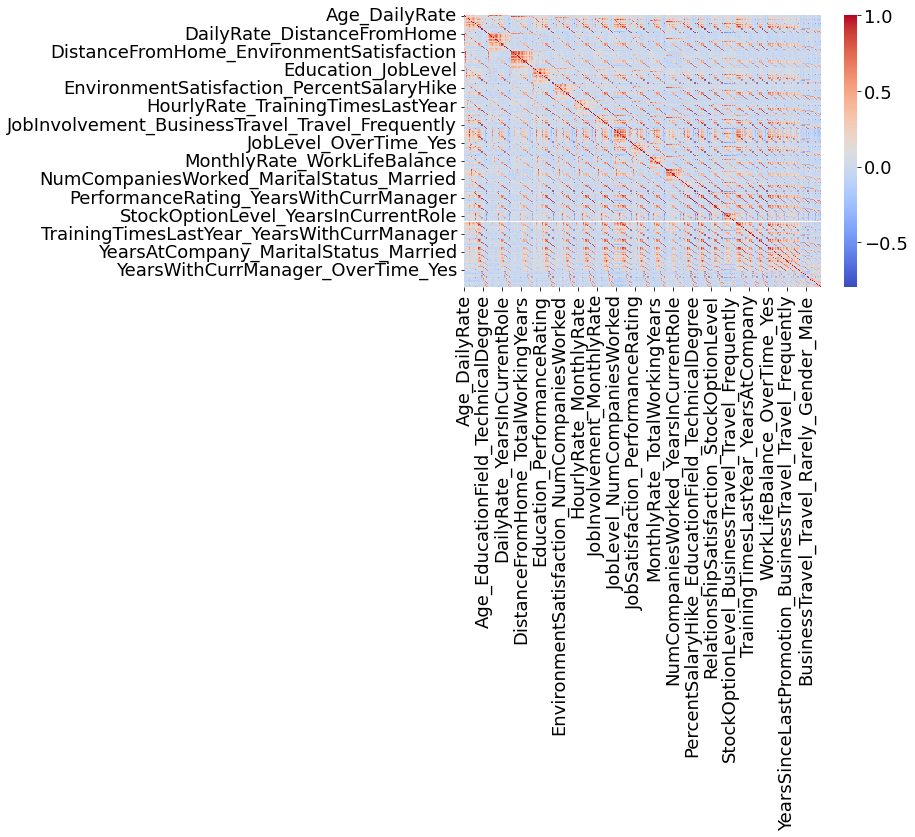

In [406]:
#Heatmap of interactions - although it's impossible to see which variables are highly multi-collinear, some are, so we need to perform VIF exploration
corr_matrix = interactions.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

**Dropping Interaction Terms with High VIF**

*By Catherine Erickson*

In [407]:
#Testing VIF of interaction terms
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                                         feature          VIF
288             PerformanceRating_YearsAtCompany  1732.315951
18                            Age_YearsAtCompany  1576.219286
285          PerformanceRating_TotalWorkingYears  1225.310284
289         PerformanceRating_YearsInCurrentRole   903.783071
291       PerformanceRating_YearsWithCurrManager   893.357659
..                                           ...          ...
81    DistanceFromHome_JobRole_ResearchScientist     6.649377
428                     Gender_Male_OverTime_Yes     6.299596
431       JobRole_ResearchScientist_OverTime_Yes     5.545099
424  EducationField_TechnicalDegree_OverTime_Yes     4.579341
329        StockOptionLevel_MaritalStatus_Single          NaN

[434 rows x 2 columns]


In [408]:
#Making a list of all null VIF values and values greater than 500
#Dropping variables in chunks because we want to get down to a 10 threshold, and currently lots of variables are a lot higher. 
#Since there are 464 rows, it takes VIF several minutes to run, so it is not practical to drop predictors one-by-one
vif_null = vif_data[(vif_data.VIF.isnull()) | (vif_data.VIF > 500)]
vif_null=vif_null.feature.to_list()

In [409]:
#Dropping null values and values greater than 500
interactions = interactions.drop(vif_null, axis=1)

In [410]:
#Retesting VIF without null and greater than 500 VIFs
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature         VIF
283   PerformanceRating_EducationField_TechnicalDegree  365.063626
7                                         Age_JobLevel  340.987179
14                               Age_TotalWorkingYears  298.714782
282                  PerformanceRating_WorkLifeBalance  273.722430
280                 PerformanceRating_StockOptionLevel  261.283103
..                                                 ...         ...
407  EducationField_TechnicalDegree_JobRole_Researc...    6.591883
78          DistanceFromHome_JobRole_ResearchScientist    6.477762
414                           Gender_Male_OverTime_Yes    6.131269
417             JobRole_ResearchScientist_OverTime_Yes    5.412372
410        EducationField_TechnicalDegree_OverTime_Yes    4.508093

[420 rows x 2 columns]


In [411]:
#Making a list of all VIF values greater than 100
vif_over_100 = vif_data[(vif_data["VIF"] > 100) & (vif_data["feature"] != "const")]
vif_over_100=vif_over_100.feature.to_list()

In [412]:
#Dropping values greater than 200
interactions = interactions.drop(vif_over_100, axis=1)

In [413]:
#Retesting VIF without VIFs greater than 100
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
10                  Age_EducationField_TechnicalDegree  71.261240
282               WorkLifeBalance_MaritalStatus_Single  68.544991
147                JobInvolvement_MaritalStatus_Single  66.322792
276   WorkLifeBalance_BusinessTravel_Travel_Frequently  66.299939
5                                  Age_JobSatisfaction  65.224796
..                                                 ...        ...
63          DistanceFromHome_JobRole_ResearchScientist   5.668665
338                           Gender_Male_OverTime_Yes   5.526331
331  EducationField_TechnicalDegree_JobRole_Researc...   5.291726
341             JobRole_ResearchScientist_OverTime_Yes   4.864124
334        EducationField_TechnicalDegree_OverTime_Yes   3.694239

[344 rows x 2 columns]


In [414]:
#Making a list of all VIF values greater than 40
vif_over_40 = vif_data[(vif_data["VIF"] > 40) & (vif_data["feature"] != "const")]
vif_over_40=vif_over_40.feature.to_list()

In [415]:
#Dropping values greater than 40
interactions = interactions.drop(vif_over_40, axis=1)

In [416]:
#Retesting VIF without VIFs greater than 40
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  50.789820
110      JobInvolvement_EducationField_TechnicalDegree  34.238550
89                           HourlyRate_JobInvolvement  31.806399
189      RelationshipSatisfaction_MaritalStatus_Single  31.777322
227           YearsAtCompany_JobRole_ResearchScientist  30.894997
..                                                 ...        ...
273                           Gender_Male_OverTime_Yes   5.108890
48          DistanceFromHome_JobRole_ResearchScientist   5.094697
266  EducationField_TechnicalDegree_JobRole_Researc...   4.830796
276             JobRole_ResearchScientist_OverTime_Yes   4.595497
269        EducationField_TechnicalDegree_OverTime_Yes   3.120326

[279 rows x 2 columns]


In [417]:
#Making a list of all VIF values greater than 20
vif_over_20 = vif_data[(vif_data["VIF"] > 20) & (vif_data["feature"] != "const")]
vif_over_20=vif_over_20.feature.to_list()

In [418]:
#Dropping values greater than 20
interactions = interactions.drop(vif_over_20, axis=1)

In [419]:
#Retesting VIF without VIFs greater than 20
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  28.062343
72                               JobLevel_OverTime_Yes  16.203501
100                  NumCompaniesWorked_YearsAtCompany  16.194659
69                           JobLevel_StockOptionLevel  15.867973
70           JobLevel_BusinessTravel_Travel_Frequently  15.741193
..                                                 ...        ...
35     DistanceFromHome_EducationField_TechnicalDegree   3.735682
37          DistanceFromHome_JobRole_ResearchScientist   3.558674
175  EducationField_TechnicalDegree_JobRole_Researc...   3.285057
166  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.508316
178        EducationField_TechnicalDegree_OverTime_Yes   2.334045

[188 rows x 2 columns]


In [420]:
#Making a list of all VIF values greater than 12
vif_over_12 = vif_data[(vif_data["VIF"] > 12) & (vif_data["feature"] != "const")]
vif_over_12=vif_over_12.feature.to_list()

In [421]:
#Dropping values greater than 12
interactions = interactions.drop(vif_over_12, axis=1)

In [422]:
#Retesting VIF without VIFs greater than 12
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  24.007881
40                 Education_JobRole_ResearchScientist  10.818271
23           DistanceFromHome_RelationshipSatisfaction  10.469385
18                          DistanceFromHome_Education  10.308805
130     YearsWithCurrManager_JobRole_ResearchScientist  10.297034
..                                                 ...        ...
140  EducationField_TechnicalDegree_JobRole_Researc...   3.143808
138      BusinessTravel_Travel_Frequently_OverTime_Yes   2.793693
143        EducationField_TechnicalDegree_OverTime_Yes   2.218537
133  BusinessTravel_Travel_Frequently_EducationFiel...   2.148356
135  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.147770

[153 rows x 2 columns]


In [423]:
#Making a list of all VIF values greater than 10.4
vif_over_104 = vif_data[(vif_data["VIF"] > 10.4) & (vif_data["feature"] != "const")]
vif_over_104=vif_over_104.feature.to_list()

In [424]:
#Dropping values greater than 10.4
interactions = interactions.drop(vif_over_104, axis=1)

In [425]:
#Retesting VIF without VIFs greater than 10.4
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  23.981184
45   EnvironmentSatisfaction_EducationField_Technic...  10.259241
128     YearsWithCurrManager_JobRole_ResearchScientist  10.164604
90   RelationshipSatisfaction_EducationField_Techni...  10.142913
18                          DistanceFromHome_Education  10.123373
..                                                 ...        ...
138  EducationField_TechnicalDegree_JobRole_Researc...   3.141121
136      BusinessTravel_Travel_Frequently_OverTime_Yes   2.793421
141        EducationField_TechnicalDegree_OverTime_Yes   2.214869
133  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.142314
131  BusinessTravel_Travel_Frequently_EducationFiel...   2.139076

[151 rows x 2 columns]


In [426]:
#Making a list of all VIF values greater than 10.4
vif_over_101 = vif_data[(vif_data["VIF"] > 10.1) & (vif_data["feature"] != "const")]
vif_over_101=vif_over_101.feature.to_list()

In [427]:
#Dropping values greater than 10.1
interactions = interactions.drop(vif_over_101, axis=1)

In [428]:
#Retesting VIF without VIFs greater than 10.1
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  23.819264
39                 EnvironmentSatisfaction_MonthlyRate   9.934601
5                            DailyRate_JobSatisfaction   9.905620
37                               Education_Gender_Male   9.749060
53             JobSatisfaction_YearsSinceLastPromotion   9.736759
..                                                 ...        ...
132      BusinessTravel_Travel_Frequently_OverTime_Yes   2.770239
134  EducationField_TechnicalDegree_JobRole_Researc...   2.486790
129  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.128085
136        EducationField_TechnicalDegree_OverTime_Yes   2.104966
127  BusinessTravel_Travel_Frequently_EducationFiel...   1.939527

[146 rows x 2 columns]


**Forward Selection of Interaction Terms Only**

*By Ally Bardas, Annabel Skubisz, Karrine Denisova, and Catherine Erickson*

In [429]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = interactions[interactions.columns]
train_transformations = pd.concat([interactions, pd.DataFrame(y_train_resampled),],axis =1)

In [430]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.692345
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688569
  

Optimization terminated successfully.
         Current function value: 0.666924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693082
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690736
  

Optimization terminated successfully.
         Current function value: 0.634289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636510
  

Optimization terminated successfully.
         Current function value: 0.634549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635826
  

Optimization terminated successfully.
         Current function value: 0.610251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613115
  

Optimization terminated successfully.
         Current function value: 0.587147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.581899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591705
  

Optimization terminated successfully.
         Current function value: 0.593519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587819
  

Optimization terminated successfully.
         Current function value: 0.575815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.571124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.571662
  

Optimization terminated successfully.
         Current function value: 0.572578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572596
         Iterations 6
Processed  141 models on 5 predictors in 1.3111662864685059 seconds.
Optimization terminated successfully.
         Current function value: 0.562905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559221
         Iterations 6
Optimization 

Optimization terminated successfully.
         Current function value: 0.563031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552015
  

Optimization terminated successfully.
         Current function value: 0.550871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550405
  

Optimization terminated successfully.
         Current function value: 0.548467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549257
  

Optimization terminated successfully.
         Current function value: 0.540953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540077
  

Optimization terminated successfully.
         Current function value: 0.530575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528647
  

Optimization terminated successfully.
         Current function value: 0.532406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531669
  

Optimization terminated successfully.
         Current function value: 0.523356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521047
  

Optimization terminated successfully.
         Current function value: 0.514147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512303
  

Optimization terminated successfully.
         Current function value: 0.514559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516181
  

Optimization terminated successfully.
         Current function value: 0.509409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505435
  

Optimization terminated successfully.
         Current function value: 0.502678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502742
  

Optimization terminated successfully.
         Current function value: 0.501446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501362
  

Optimization terminated successfully.
         Current function value: 0.493583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495372
  

Optimization terminated successfully.
         Current function value: 0.494628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495876
         Iterations 6
Processed  132 models on 14 predictors in 2.66851806640625 seconds.
Optimization terminated successfully.
         Current function value: 0.486696
         Iterations 6
Optimization t

Optimization terminated successfully.
         Current function value: 0.489060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489009
  

Optimization terminated successfully.
         Current function value: 0.480559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484020
  

Optimization terminated successfully.
         Current function value: 0.483907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481919
  

Optimization terminated successfully.
         Current function value: 0.477946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478273
  

Optimization terminated successfully.
         Current function value: 0.474732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474541
  

Optimization terminated successfully.
         Current function value: 0.473173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473992
  

Optimization terminated successfully.
         Current function value: 0.471114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470492
  

Optimization terminated successfully.
         Current function value: 0.468185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468141
  

Optimization terminated successfully.
         Current function value: 0.468460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468311
  

Optimization terminated successfully.
         Current function value: 0.465570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463613
  

Optimization terminated successfully.
         Current function value: 0.462769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462664
  

Optimization terminated successfully.
         Current function value: 0.462819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462133
  

Optimization terminated successfully.
         Current function value: 0.460341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460136
  

Optimization terminated successfully.
         Current function value: 0.457795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457873
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457888
  

Optimization terminated successfully.
         Current function value: 0.456564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457256
         Iterations 7
Processed  122 models on 24 predictors in 3.491576910018921 seconds.
Optimization terminated successfully.
         Current function value: 0.454868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455646
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.455591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455447
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454540
  

Optimization terminated successfully.
         Current function value: 0.453727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453476
  

Optimization terminated successfully.
         Current function value: 0.453576
         Iterations 7
Processed  120 models on 26 predictors in 3.689757823944092 seconds.
Optimization terminated successfully.
         Current function value: 0.450487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451469
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.451390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451058
  

Optimization terminated successfully.
         Current function value: 0.449073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448780
  

Optimization terminated successfully.
         Current function value: 0.447145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447351
  

Optimization terminated successfully.
         Current function value: 0.447223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447241
  

Optimization terminated successfully.
         Current function value: 0.444495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444410
  

Optimization terminated successfully.
         Current function value: 0.443557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443704
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442778
  

Optimization terminated successfully.
         Current function value: 0.443582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443554
  

Optimization terminated successfully.
         Current function value: 0.440327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441098
  

Optimization terminated successfully.
         Current function value: 0.438347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438186
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438883
  

Optimization terminated successfully.
         Current function value: 0.436775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436931
  

Optimization terminated successfully.
         Current function value: 0.436356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436730
  

Optimization terminated successfully.
         Current function value: 0.435043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433911
  

Optimization terminated successfully.
         Current function value: 0.433286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433578
  

Optimization terminated successfully.
         Current function value: 0.431357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431064
  

Optimization terminated successfully.
         Current function value: 0.431289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430957
  

Optimization terminated successfully.
         Current function value: 0.429539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429079
  

Optimization terminated successfully.
         Current function value: 0.428645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428983
  

Optimization terminated successfully.
         Current function value: 0.427719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427780
  

Optimization terminated successfully.
         Current function value: 0.427644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427466
  

Optimization terminated successfully.
         Current function value: 0.426070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426071
  

Optimization terminated successfully.
         Current function value: 0.423282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423309
  

Optimization terminated successfully.
         Current function value: 0.421203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420461
  

Optimization terminated successfully.
         Current function value: 0.418236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418399
  

Optimization terminated successfully.
         Current function value: 0.417777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417717
  

Optimization terminated successfully.
         Current function value: 0.413241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413092
  

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411119
  

Optimization terminated successfully.
         Current function value: 0.409151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.408517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409479
  

Optimization terminated successfully.
         Current function value: 0.406415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407460
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407425
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407308
  

Optimization terminated successfully.
         Current function value: 0.407682
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406641
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406231
         Iterations 8
Processed  98 models on 48 predictors in 5.6377599239349365 seconds.
Optimization terminated successfully.
         Current function value: 0.405834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406083
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.404541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406078
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406024
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405647
  

Optimization terminated successfully.
         Current function value: 0.404146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404245
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404213
  

Optimization terminated successfully.
         Current function value: 0.402574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402529
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402447
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402562
  

Optimization terminated successfully.
         Current function value: 0.401107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400187
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400798
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400388
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400913
  

Optimization terminated successfully.
         Current function value: 0.399900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399763
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399655
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399613
  

Optimization terminated successfully.
         Current function value: 0.397897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398597
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398307
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397971
  

Optimization terminated successfully.
         Current function value: 0.398394
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398241
         Iterations 8
Processed  92 models on 54 predictors in 5.680819988250732 seconds.
Optimization terminated successfully.
         Current function value: 0.397335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397361
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396772
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.397390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396797
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396565
  

Optimization terminated successfully.
         Current function value: 0.396297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395788
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395501
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396282
  

Optimization terminated successfully.
         Current function value: 0.394728
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394486
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394759
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394544
  

Optimization terminated successfully.
         Current function value: 0.393575
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393546
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393387
  

Optimization terminated successfully.
         Current function value: 0.392148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392218
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392556
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392520
  

Optimization terminated successfully.
         Current function value: 0.391452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391385
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391438
  

Optimization terminated successfully.
         Current function value: 0.389750
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389700
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389361
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388892
  

Optimization terminated successfully.
         Current function value: 0.388506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388877
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388875
  

Optimization terminated successfully.
         Current function value: 0.387763
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387750
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387359
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387762
  

Optimization terminated successfully.
         Current function value: 0.386861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386857
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386872
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386650
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386870
  

Optimization terminated successfully.
         Current function value: 0.385982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385768
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385981
  

Optimization terminated successfully.
         Current function value: 0.384948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384717
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384947
  

Optimization terminated successfully.
         Current function value: 0.384085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384104
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383947
  

Optimization terminated successfully.
         Current function value: 0.383079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382891
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383163
  

Optimization terminated successfully.
         Current function value: 0.382082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381922
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382081
  

Optimization terminated successfully.
         Current function value: 0.381047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381162
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381207
  

Optimization terminated successfully.
         Current function value: 0.380135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379597
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379876
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380097
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380015
  

Optimization terminated successfully.
         Current function value: 0.378566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378522
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378635
  

Optimization terminated successfully.
         Current function value: 0.377618
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377681
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376857
  

Optimization terminated successfully.
         Current function value: 0.375490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376548
         Iterations 8
Processed  72 models on 74 predictors in 5.863658905029297 seconds.
Optimization terminated successfully.
         Current function value: 0.375393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375309
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375311
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374882
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.374454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373973
  

Optimization terminated successfully.
         Current function value: 0.373482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373337
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373565
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373572
  

Optimization terminated successfully.
         Current function value: 0.372470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372033
  

Optimization terminated successfully.
         Current function value: 0.371893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371865
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371945
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371631
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371880
  

Optimization terminated successfully.
         Current function value: 0.371106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370756
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370710
         Iterations 8
Processed  66 models on 80 predictors in 6.200501203536987 seconds.
Optimization t

Optimization terminated successfully.
         Current function value: 0.369430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369453
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369425
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369100
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369495
  

Optimization terminated successfully.
         Current function value: 0.368689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368923
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368682
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368750
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368936
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368795
  

Optimization terminated successfully.
         Current function value: 0.368473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368501
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368432
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368337
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368222
  

Optimization terminated successfully.
         Current function value: 0.368020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367985
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367945
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367887
         Iterations 8
Processed  61 models on 85 predictors in 5.6599390506744385 seconds.
Optimization terminated successfully.
         Current function value: 0.367575
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367546
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367638
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.367211
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367109
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367134
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366990
  

Optimization terminated successfully.
         Current function value: 0.366537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366776
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366773
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366119
  

Optimization terminated successfully.
         Current function value: 0.364974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364975
  

Optimization terminated successfully.
         Current function value: 0.364552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364319
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364647
  

Optimization terminated successfully.
         Current function value: 0.364239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364156
         Iterations 8
Processed  54 models on 92 predictors in 5.8305559158325195 seconds.
Optimization terminated successfully.
         Current function value: 0.363825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363930
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363926
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.363390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363359
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363607
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363525
  

Optimization terminated successfully.
         Current function value: 0.362962
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362841
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363034
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362851
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363032
  

Optimization terminated successfully.
         Current function value: 0.362644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362665
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362760
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362752
  

Optimization terminated successfully.
         Current function value: 0.361780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361762
  

Optimization terminated successfully.
         Current function value: 0.361184
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361248
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361286
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361282
  

Optimization terminated successfully.
         Current function value: 0.360792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360741
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360794
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360753
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360647
         Iterations 8
Processed  44 models on 102 predictors in 4.936400890350342 seconds.
Optimization terminated successfully.
         Current function value: 0.360224
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.359938
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359971
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360009
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359881
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360000
  

Optimization terminated successfully.
         Current function value: 0.359088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359089
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359161
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359248
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359220
  

Optimization terminated successfully.
         Current function value: 0.358481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358517
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358625
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358587
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358568
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358487
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358569
  

Optimization terminated successfully.
         Current function value: 0.358120
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358023
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358162
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357885
         Iterations 8
Processed  36 models on 110 predictors in 4.088764905929565 seconds.
Optimization terminated successfully.
         Current function value: 0.357867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357878
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.357505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357415
  

Optimization terminated successfully.
         Current function value: 0.357241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357208
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357267
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357279
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357207
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357183
  

Optimization terminated successfully.
         Current function value: 0.356947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356954
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356969
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356965
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356939
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356969
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356934
  

Optimization terminated successfully.
         Current function value: 0.356622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356567
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356649
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356639
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356551
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356626
  

Optimization terminated successfully.
         Current function value: 0.356272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356284
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356249
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356296
         Iterations 8
Processed  22 models on 124 predictors in 3.7762627601623535 seconds.
Optimization terminated successfully.
         Current function value: 0.356157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356144
         Iterations 8
Optimization

Optimization terminated successfully.
         Current function value: 0.355999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356011
         Iterations 8
Processed  18 models on 128 predictors in 2.677917957305908 seconds.
Optimization terminated successfully.
         Current function value: 0.355953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355961
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355964
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.355798
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355827
         Iterations 8
Processed  13 models on 133 predictors in 1.9325690269470215 seconds.
Optimization terminated successfully.
         Current function value: 0.355778
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355794
         Iterations 8
Optimization

Optimization terminated successfully.
         Current function value: 0.355678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.355679
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.355678
         Iterations 9
Processed  3 models on 143 predictors in 0.47588491439819336 seconds.
Optimization terminated successfully.
         Current function value: 0.355677
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.355678
         Iterations 9
Processed  2 models on 144 predictors in 0.375946044921875 seconds.
Optimization terminated successfully.
         Current function value: 0.355676
         Iterations 9
Processed  1 models on 145 predictors in 0.2086048126220703 seconds.
Total elapsed time: 603.4794390201569 seconds.


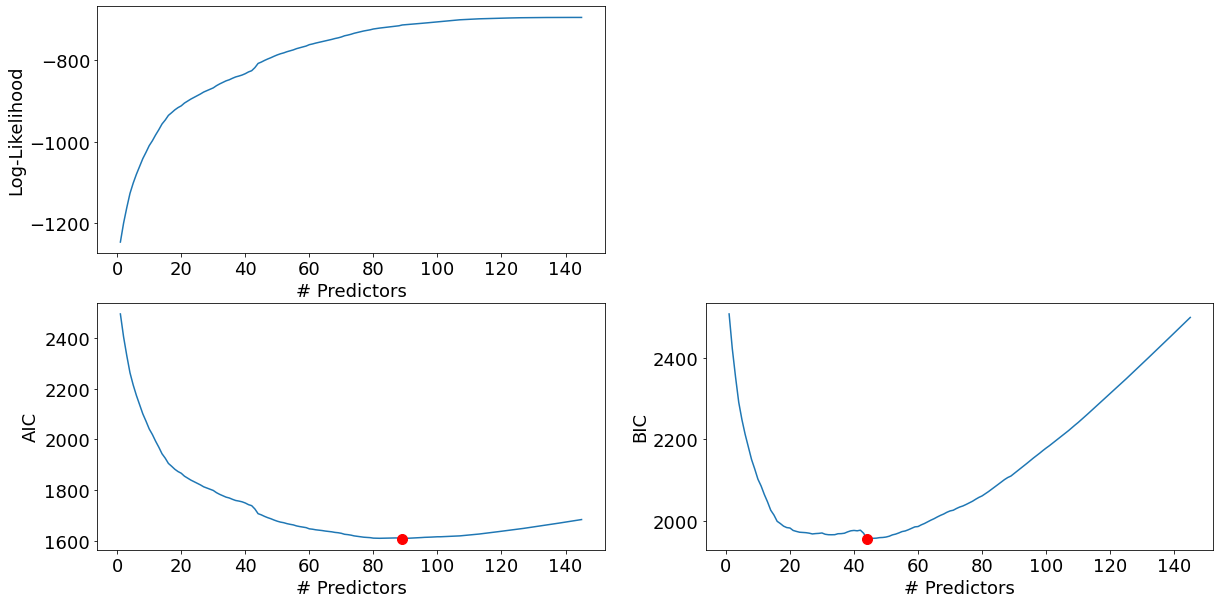

In [431]:
best_sub_plots()

In [432]:
interactions_fwd_reg_model = models_best['logit_model'][43]
interactions_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1912
Method:                           MLE   Df Model:                           43
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3962
Time:                        12:16:29   Log-Likelihood:                -818.60
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                4.352e-197
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    0.4596      0.226      2.034      0.042       0.017       0.903
MaritalStatus_Single_OverTime_Yes                            0.8046      0.275      2.925      0.003       0.266       1.344
HourlyRate_JobLevel                                         -0.0028      0.001     -2.126      0.034      -0.005      -0.000
DistanceFromHome_OverTime_Yes                                0.0679      0.014      4.826      0.000       0.040       0.095
EnvironmentSatisfaction_StockOptionLevel                    -0.2969      0.072     -4.116      0.000      -0.438      -0.155
NumCompaniesWorked_Gender_Male                               0.3163      0.051      6.241      0.000       0.217       0.416
TotalWorkingYears_Gender_Male                               -0.1069      0.017     -6.272      0.000      -0.140      -0.074
StockOptionLevel_OverTime_Yes                                0.6485      0.174      3.727      0.000       0.307       0.990
RelationshipSatisfaction_JobRole_ResearchScientist          -1.0646      0.142     -7.482      0.000      -1.344      -0.786
DailyRate_EducationField_TechnicalDegree                     0.0014      0.000      5.709      0.000       0.001       0.002
DailyRate_JobLevel                                          -0.0004      0.000     -3.530      0.000      -0.001      -0.000
YearsSinceLastPromotion_MaritalStatus_Married                0.3043      0.050      6.143      0.000       0.207       0.401
DistanceFromHome_YearsInCurrentRole                         -0.0062      0.002     -3.531      0.000      -0.010      -0.003
DistanceFromHome_BusinessTravel_Travel_Frequently            0.0528      0.019      2.715      0.007       0.015       0.091
JobRole_ResearchScientist_MaritalStatus_Single               3.0848      0.483      6.387      0.000       2.138       4.031
JobSatisfaction_TrainingTimesLastYear                       -0.0595      0.019     -3.153      0.002      -0.097      -0.023
TrainingTimesLastYear_Gender_Male                            0.2779      0.075      3.700      0.000       0.131       0.425
YearsInCurrentRole_BusinessTravel_Travel_Frequently         -0.3145      0.056     -5.622      0.000      -0.424      -0.205
MonthlyRate_BusinessTravel_Travel_Frequently              6.579e-05   1.81e-05      3.640      0.000    3.04e-05       0.000
JobRole_ResearchScientist_OverTime_Yes                       1.1430      0.369      3.094      0.002       0.419       1.867
EnvironmentSatisfaction_NumCompaniesWorked                  -0.1317      0.017     -7.693      0.000      -0.165      -0.098
DailyRate_NumCompaniesWorked                                 0.0002   4.76e-05      5.089      0.000       0.000       0.000
YearsSinceLastPromotion_MaritalStatus_Single                 0.1582      0.051      3.084      0.002       0.058    

**Combine the two models**

*By Catherine Erickson*

In [436]:
#Making a list of the params used in the model without interactions
singular_variables = singular_fwd_reg_model.params.keys().to_list()

#dropping params that are transitions - will add back, but these columns aren't in the original train and test
names_to_remove = ['WorkLifeBalance_log', 'YearsSinceLastPromotion_quadratic', 'YearsInCurrentRole_quadratic','PercentSalaryHike_log', 'Intercept']

for name in names_to_remove:
    while name in singular_variables:
        singular_variables.remove(name)

In [438]:
interactions_fwd_reg_model.params.keys().to_list()

['Intercept',
 'MaritalStatus_Single_OverTime_Yes',
 'HourlyRate_JobLevel',
 'DistanceFromHome_OverTime_Yes',
 'EnvironmentSatisfaction_StockOptionLevel',
 'NumCompaniesWorked_Gender_Male',
 'TotalWorkingYears_Gender_Male',
 'StockOptionLevel_OverTime_Yes',
 'RelationshipSatisfaction_JobRole_ResearchScientist',
 'DailyRate_EducationField_TechnicalDegree',
 'DailyRate_JobLevel',
 'YearsSinceLastPromotion_MaritalStatus_Married',
 'DistanceFromHome_YearsInCurrentRole',
 'DistanceFromHome_BusinessTravel_Travel_Frequently',
 'JobRole_ResearchScientist_MaritalStatus_Single',
 'JobSatisfaction_TrainingTimesLastYear',
 'TrainingTimesLastYear_Gender_Male',
 'YearsInCurrentRole_BusinessTravel_Travel_Frequently',
 'MonthlyRate_BusinessTravel_Travel_Frequently',
 'JobRole_ResearchScientist_OverTime_Yes',
 'EnvironmentSatisfaction_NumCompaniesWorked',
 'DailyRate_NumCompaniesWorked',
 'YearsSinceLastPromotion_MaritalStatus_Single',
 'DailyRate_YearsSinceLastPromotion',
 'NumCompaniesWorked_OverTime

### Code fitting the final model

*By Catherine Erickson and Annabel Skubisz*

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [447]:
#Combining the predictors that forward selection with transformations but without interactions and forward selection with only interactions into one formula
formula = 'Attrition_Yes~'+'+'.join(singular_variables)+'+np.log(WorkLifeBalance)+I(YearsSinceLastPromotion**2)+I(YearsInCurrentRole**2)+np.log(PercentSalaryHike)+MaritalStatus_Single*OverTime_Yes+HourlyRate*JobLevel+DistanceFromHome*OverTime_Yes+EnvironmentSatisfaction*StockOptionLevel+NumCompaniesWorked*Gender_Male+TotalWorkingYears*Gender_Male+StockOptionLevel*OverTime_Yes+RelationshipSatisfaction*JobRole_ResearchScientist+DailyRate*EducationField_TechnicalDegree+DailyRate*JobLevel+YearsSinceLastPromotion*MaritalStatus_Married+DistanceFromHome*YearsInCurrentRole+DistanceFromHome*BusinessTravel_Travel_Frequently+JobRole_ResearchScientist*MaritalStatus_Single+JobSatisfaction*TrainingTimesLastYear+TrainingTimesLastYear*Gender_Male+YearsInCurrentRole*BusinessTravel_Travel_Frequently+MonthlyRate*BusinessTravel_Travel_Frequently+JobRole_ResearchScientist*OverTime_Yes+EnvironmentSatisfaction*NumCompaniesWorked+DailyRate*NumCompaniesWorked+YearsSinceLastPromotion*MaritalStatus_Single+DailyRate*YearsSinceLastPromotion+NumCompaniesWorked*OverTime_Yes+EnvironmentSatisfaction*BusinessTravel_Travel_Frequently+NumCompaniesWorked*YearsSinceLastPromotion+BusinessTravel_Travel_Frequently*MaritalStatus_Married+StockOptionLevel*BusinessTravel_Travel_Frequently+StockOptionLevel*YearsSinceLastPromotion+StockOptionLevel*Gender_Male+StockOptionLevel*BusinessTravel_Travel_Rarely+DailyRate*StockOptionLevel+DailyRate*DistanceFromHome+EducationField_TechnicalDegree*JobRole_ResearchScientist+TotalWorkingYears*JobRole_ResearchScientist+YearsSinceLastPromotion*JobRole_ResearchScientist+JobRole_ResearchScientist*MaritalStatus_Married+StockOptionLevel*TotalWorkingYears+StockOptionLevel*TrainingTimesLastYear+JobSatisfaction*Gender_Male+EnvironmentSatisfaction*Gender_Male+MonthlyRate*MaritalStatus_Married+TrainingTimesLastYear*MaritalStatus_Married'

In [448]:
final_model = smf.logit(formula = formula, data =train_singular).fit()
final_model.summary()

Optimization terminated successfully.
         Current function value: 0.345464
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1878
Method:                           MLE   Df Model:                           77
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5016
Time:                        12:30:57   Log-Likelihood:                -675.73
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                9.294e-234
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.1885      1.605      2.609      0.009       1.042       7.335
OverTime_Yes                                                 1.3939      0.427      3.266      0.001       0.557       2.230
MaritalStatus_Single                                         1.4876      0.397      3.744      0.000       0.709       2.266
JobLevel                                                     0.5969      0.353      1.689      0.091      -0.096       1.290
JobInvolvement                                              -0.5267      0.109     -4.828      0.000      -0.740      -0.313
JobRole_ResearchScientist                                    1.6812      0.950      1.769      0.077      -0.181       3.544
EducationField_TechnicalDegree                               0.4461      0.620      0.719      0.472      -0.770       1.662
EnvironmentSatisfaction                                     -0.5170      0.146     -3.536      0.000      -0.804      -0.230
JobSatisfaction                                             -0.3755      0.200     -1.877      0.060      -0.768       0.017
BusinessTravel_Travel_Frequently                             2.3698      0.808      2.934      0.003       0.787       3.953
YearsInCurrentRole                                          -0.2180      0.084     -2.590      0.010      -0.383      -0.053
YearsAtCompany                                               0.1817      0.030      6.079      0.000       0.123       0.240
NumCompaniesWorked                                           0.0729      0.105      0.692      0.489      -0.134       0.279
TotalWorkingYears                                           -0.1359      0.028     -4.901      0.000      -0.190      -0.082
DistanceFromHome                                             0.0527      0.026      2.057      0.040       0.002       0.103
BusinessTravel_Travel_Rarely                                 0.4017      0.386      1.041      0.298      -0.355       1.158
MaritalStatus_Married                                       -0.4413      0.537     -0.822      0.411      -1.494       0.611
JobRole_ResearchDirector                                    -2.3779      0.643     -3.698      0.000      -3.638      -1.118
YearsWithCurrManager                                        -0.0790      0.038     -2.076      0.038      -0.154      -0.004
Gender_Male                                                 -3.0135      0.755     -3.992      0.000      -4.493      -1.534
YearsSinceLastPromotion                                      0.0145      0.154      0.095      0.925      -0.287       0.316
JobRole_SalesRepresentative                                  2.5387      0.381      6.658      0.000       1.791       3.286
TrainingTimesLastYear                                       -0.6694      0.181     -3.695      0.000      -1.025    

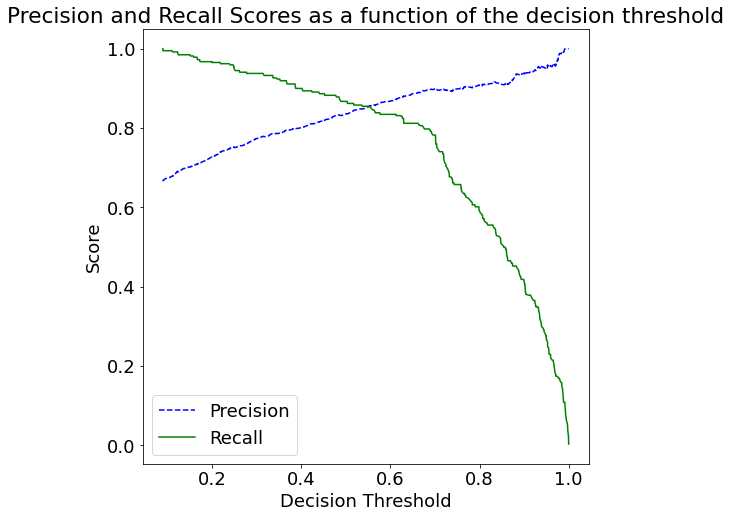

In [449]:
y=train.Attrition_Yes
ypred = final_model.predict(train_singular)
p, r, thresholds = precision_recall_curve(y, ypred)

plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 85.4%
Precision = 86.9%
TPR or Recall = 83.4%
FNR = 16.6%
FPR = 12.6%
ROC-AUC = 92.4%


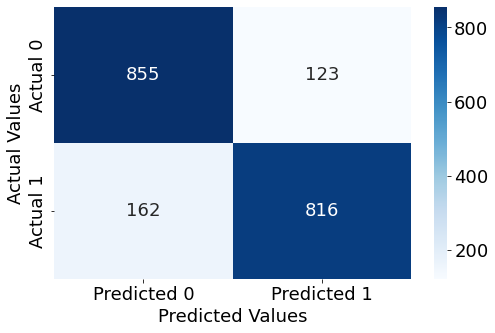

In [450]:
confusion_matrix_data(train_singular,train_singular.Attrition_Yes,final_model,0.6)

Classification accuracy = 80.3%
Precision = 34.4%
TPR or Recall = 53.8%
FNR = 46.2%
FPR = 15.7%
ROC-AUC = 74.6%


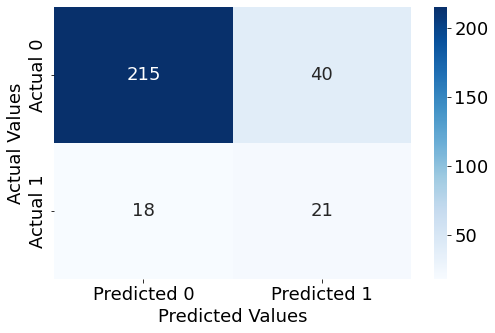

In [451]:
confusion_matrix_data(test,test.Attrition_Yes,final_model,0.6)

0.92378753852652


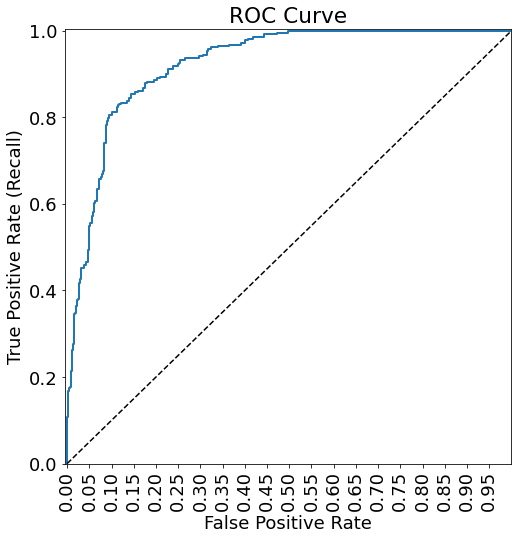

In [452]:
y=train_singular.Attrition_Yes
ypred = final_model.predict(train_singular)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)